# Option pricing error distributions (outliers removed)
This notebook loads per-year option pricing error observations, removes previously-detected outliers per company, and plots the distribution of **absolute percentage change** along with a fitted Normal(μ, σ).

In [20]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm

plt.style.use('seaborn-v0_8-whitegrid')
ART_DIR = Path('./artifacts')


In [21]:
# Load cleaned observations (outliers removed)
clean_path = ART_DIR / 'obs_long_clean_no_outliers.csv'
raw_path = ART_DIR / 'obs_long_clean.csv'
out_path = ART_DIR / 'outliers.csv'

if clean_path.exists():
    obs = pd.read_csv(clean_path)
    print(f'Loaded cleaned observations: {len(obs):,} rows from {clean_path}')
else:
    # Fallback: reconstruct by removing outlier keys if needed
    if not raw_path.exists():
        raise FileNotFoundError(f'Missing {clean_path} and {raw_path}. Run the outlier-removal step first.')
    obs_raw = pd.read_csv(raw_path)
    if out_path.exists():
        outliers = pd.read_csv(out_path)
    else:
        outliers = pd.DataFrame(columns=['company','window_end_index'])

    for c in ['company','file']:
        if c in obs_raw.columns: obs_raw[c] = obs_raw[c].astype(str)
        if c in outliers.columns: outliers[c] = outliers[c].astype(str)
    obs_raw['window_end_index'] = pd.to_numeric(obs_raw['window_end_index'], errors='coerce')
    outliers['window_end_index'] = pd.to_numeric(outliers['window_end_index'], errors='coerce')

    key_cols = ['company','window_end_index']
    out_keys = outliers[key_cols].dropna().drop_duplicates()
    obs = obs_raw.merge(out_keys.assign(_is_outlier=1), on=key_cols, how='left')
    obs = obs[obs['_is_outlier'].isna()].drop(columns=['_is_outlier'])
    obs.to_csv(clean_path, index=False)
    print(f'Reconstructed and wrote cleaned observations: {len(obs):,} rows to {clean_path}')

# Basic hygiene
obs['abs_pct_change'] = pd.to_numeric(obs['abs_pct_change'], errors='coerce')
obs = obs.dropna(subset=['company','abs_pct_change'])
obs['company'] = obs['company'].astype(str)
obs.head()

Loaded cleaned observations: 1,070 rows from artifacts/obs_long_clean_no_outliers.csv


,company,file,window_end_index,S0,sigma,option_price,future_price,pct_change,abs_pct_change
0,GE,GE_Vernova_us_d.csv,220,375.200,0.542257,85.416768,834.61,99.678367,99.678367
1,amazon,amazon_us_d.csv,6978,226.630,0.550722,52.316841,204.90,-32.673009,32.673009
2,amazon,amazon_us_d.csv,6726,169.800,0.558459,39.692391,226.65,10.104599,10.104599
3,amazon,amazon_us_d.csv,6474,99.700,0.566037,23.590011,170.98,47.833490,47.833490
4,amazon,amazon_us_d.csv,6222,153.294,0.568807,36.430446,99.54,-58.831035,58.831035


In [22]:
# Per-company summary stats and Normal(μ,σ) fit on cleaned data
def summarize_company(x: pd.Series) -> dict:
    x = x.dropna().astype(float)
    if len(x) == 0:
        return dict(n_obs=0)
    mu = float(x.mean())
    sd = float(x.std(ddof=1)) if len(x) > 1 else 0.0
    med = float(x.median())
    q1 = float(x.quantile(0.25))
    q3 = float(x.quantile(0.75))
    iqr = q3 - q1
    return {
        'n_obs': int(len(x)),
        'mean_abs_pct': mu,
        'median_abs_pct': med,
        'std_abs_pct': sd,
        'min_abs_pct': float(x.min()),
        'q1_abs_pct': q1,
        'q3_abs_pct': q3,
        'max_abs_pct': float(x.max()),
        'iqr_abs_pct': float(iqr),
        'normal_fit_mu': mu,
        'normal_fit_sigma': sd,
    }

summary_rows = []
for company, df_c in obs.groupby('company'):
    row = {'company': company}
    row.update(summarize_company(df_c['abs_pct_change']))
    summary_rows.append(row)

summary = pd.DataFrame(summary_rows).sort_values(['mean_abs_pct'], ascending=False)
summary_path = ART_DIR / 'summary_no_outliers.csv'
summary.to_csv(summary_path, index=False)
print(f'Wrote: {summary_path}')
summary.head(15)

Wrote: artifacts/summary_no_outliers.csv


,company,n_obs,mean_abs_pct,median_abs_pct,std_abs_pct,min_abs_pct,q1_abs_pct,q3_abs_pct,max_abs_pct,iqr_abs_pct,normal_fit_mu,normal_fit_sigma
0,GE,1,99.678367,99.678367,0.000000,99.678367,99.678367,99.678367,99.678367,0.000000,99.678367,0.000000
21,plug,12,78.926079,82.283336,34.132810,17.725947,60.730600,104.056734,128.965004,43.326134,78.926079,34.132810
10,enph,11,67.007310,61.792581,37.603983,11.174504,47.530019,82.533661,135.326261,35.003642,67.007310,37.603983
13,fslr,18,47.157574,47.417392,30.383278,4.476698,22.666597,60.458235,116.891262,37.791638,47.157574,30.383278
2,apple,39,35.148565,30.458138,27.024042,3.004394,10.540485,53.354242,101.463367,42.813757,35.148565,27.024042
1,amazon,26,31.794493,28.156923,18.583015,4.147734,20.168374,43.497220,70.566042,23.328845,31.794493,18.583015
25,tesla,12,27.825070,21.794491,20.417970,2.550853,9.941535,50.883120,56.359982,40.941585,27.825070,20.417970
28,walmart,52,27.594026,22.488458,24.516750,0.014167,7.458445,42.143048,92.630127,34.684603,27.594026,24.516750
11,eog,32,23.638898,25.690735,14.734058,1.442101,12.187462,32.636129,62.148299,20.448668,23.638898,14.734058
16,kmi,14,23.446549,17.127306,20.962610,0.020403,9.433915,38.358136,75.501126,28.924222,23.446549,20.962610


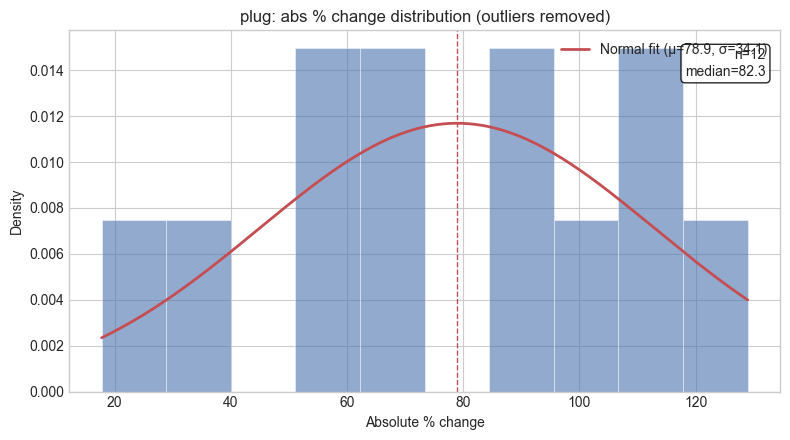

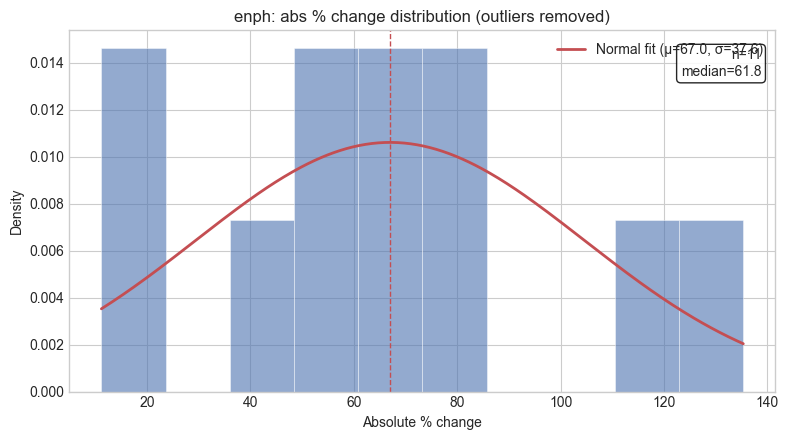

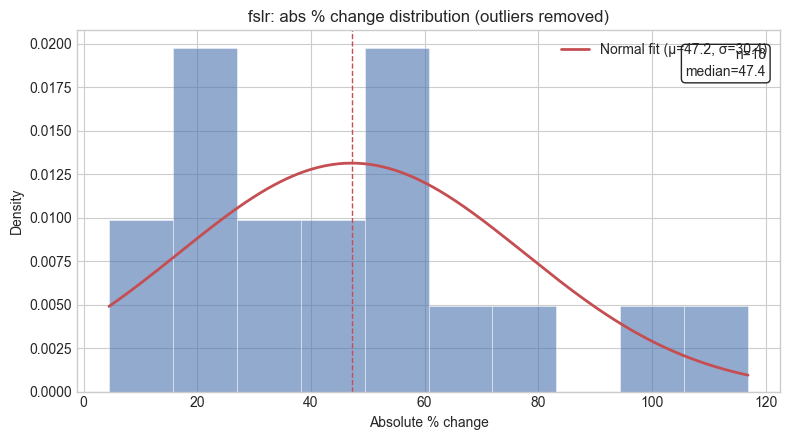

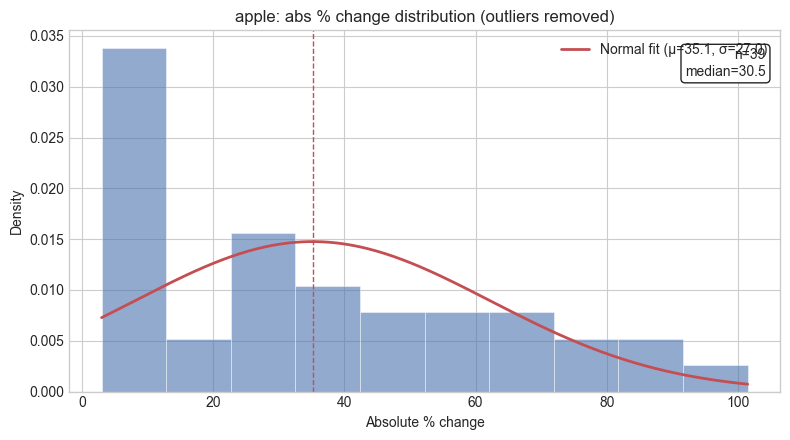

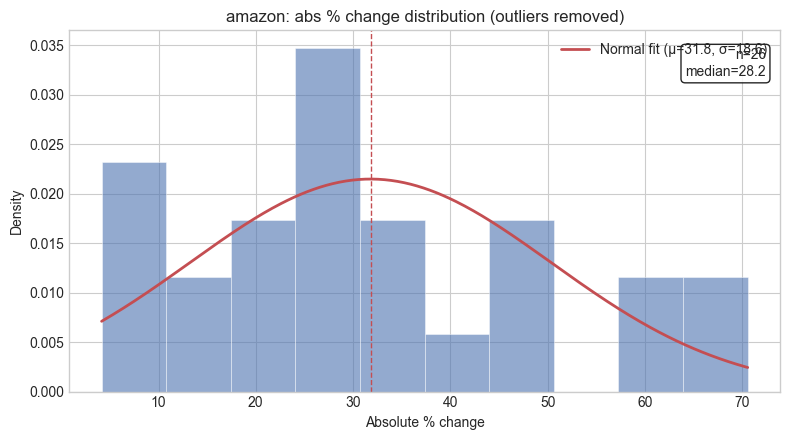

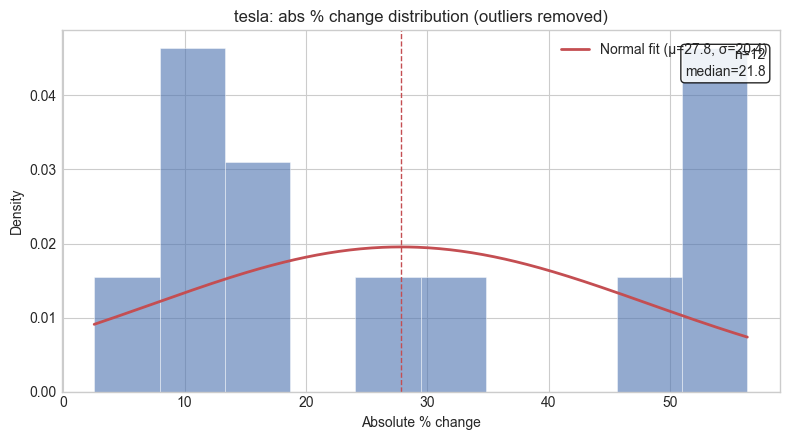

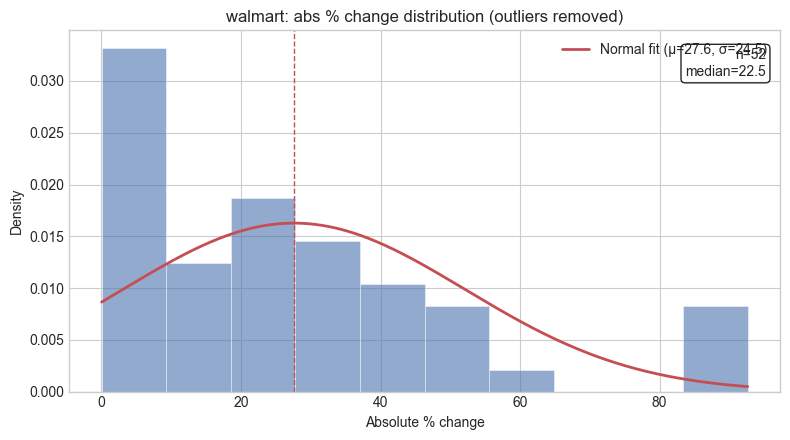

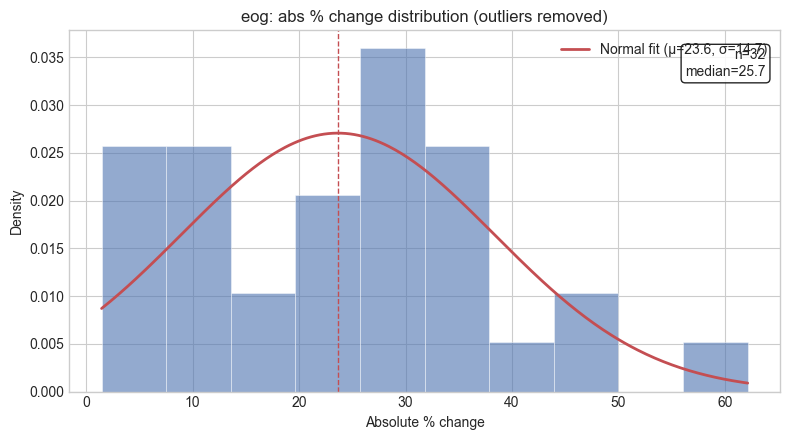

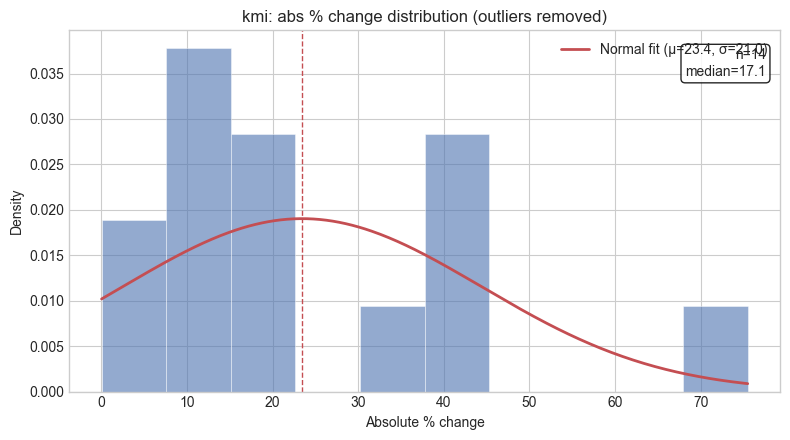

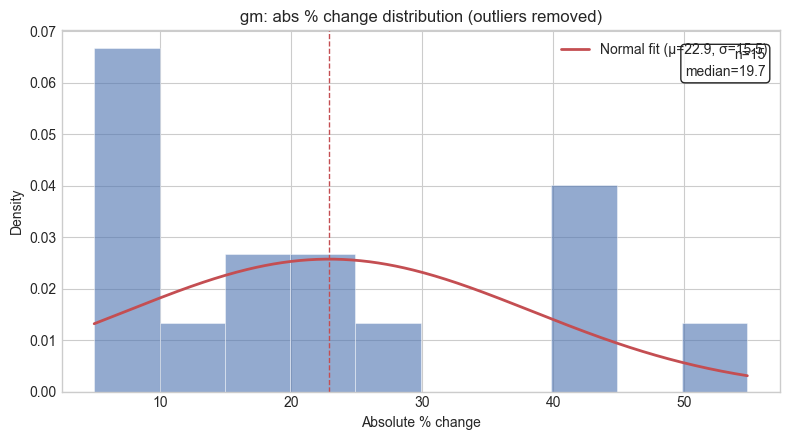

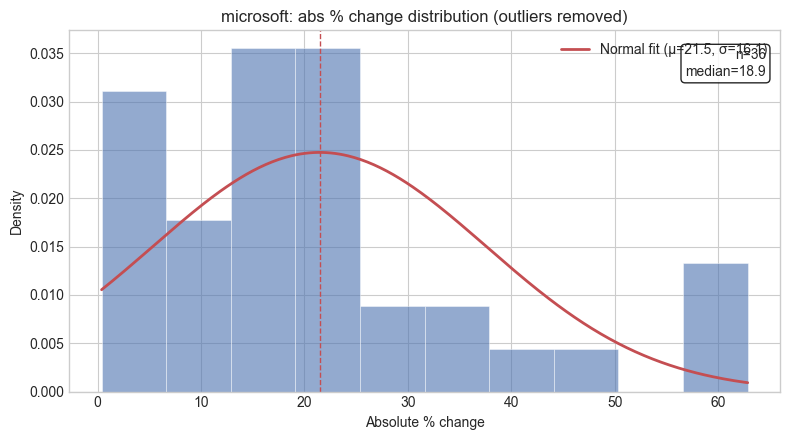

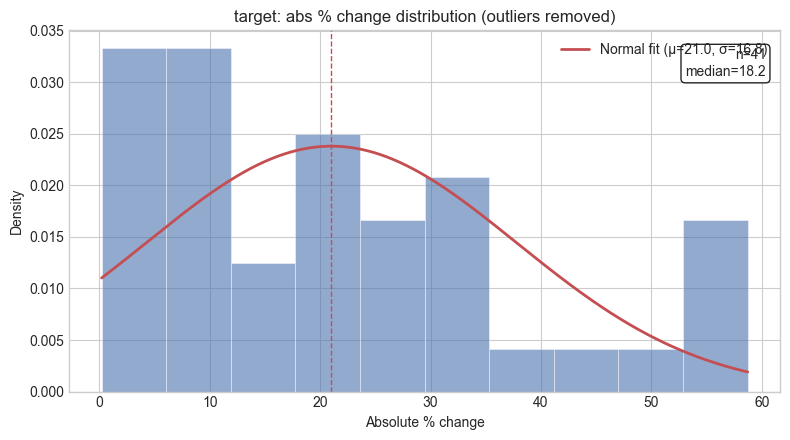

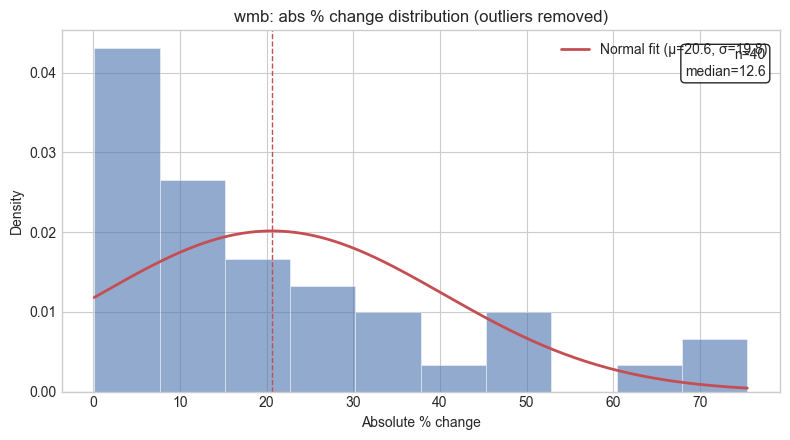

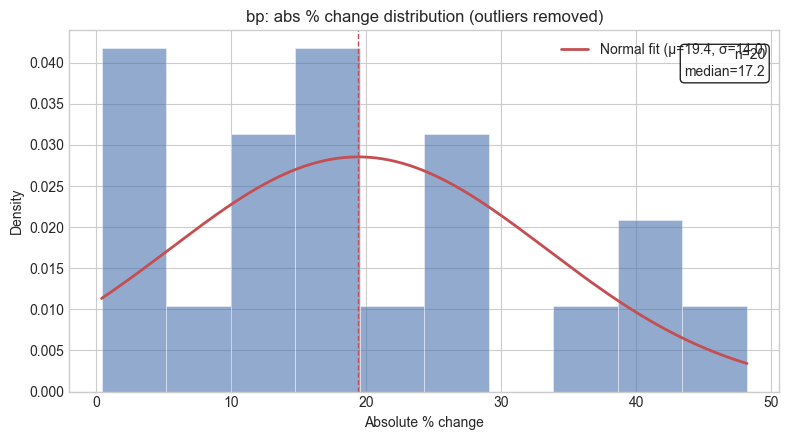

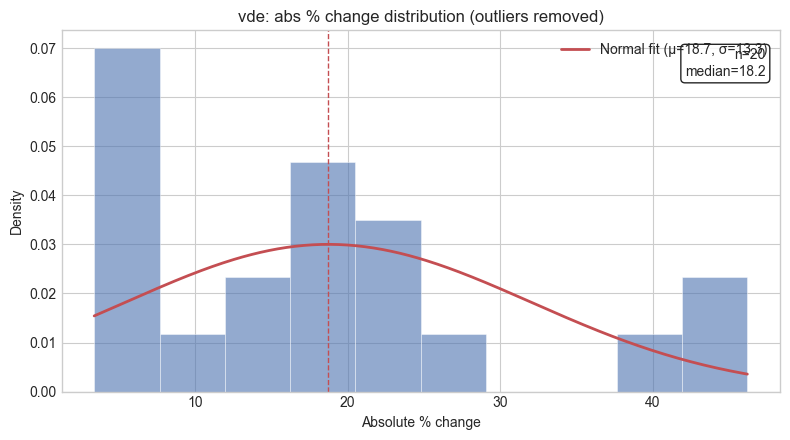

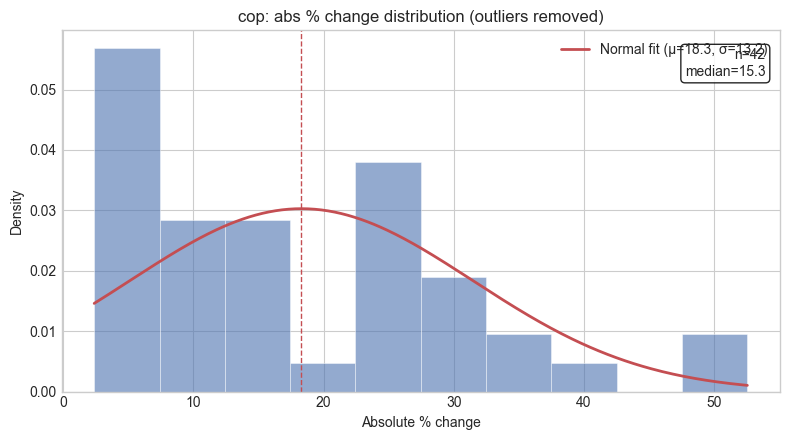

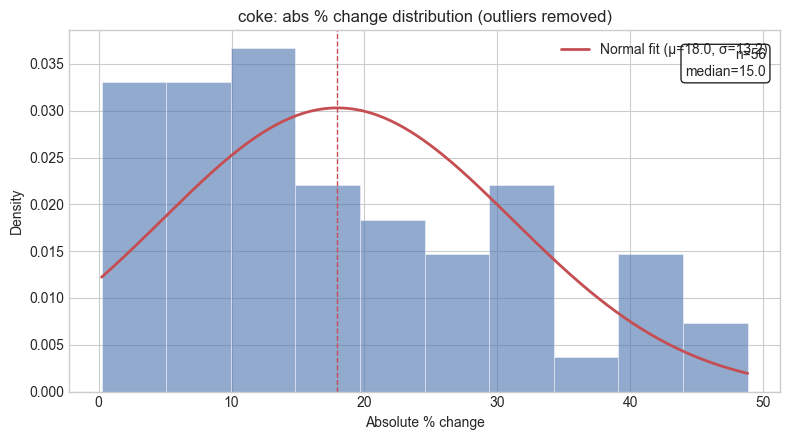

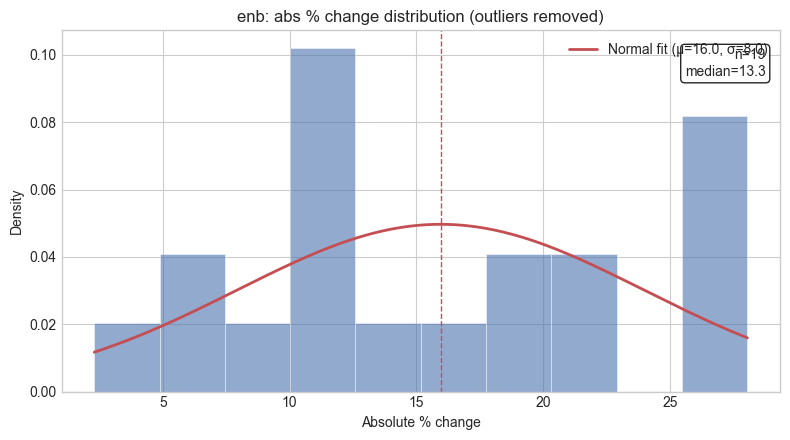

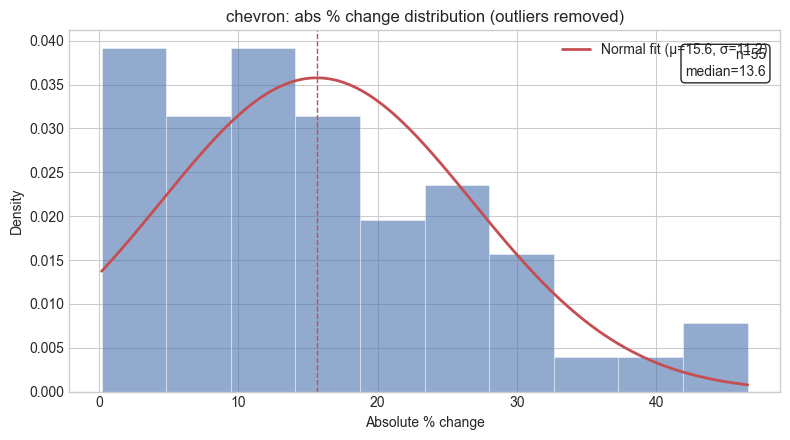

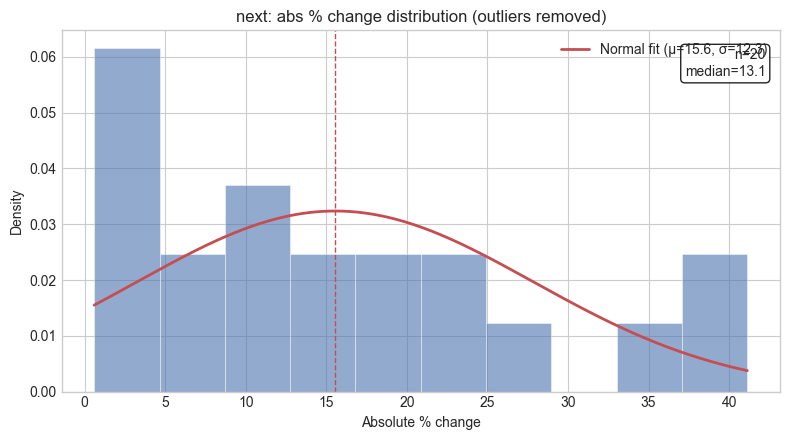

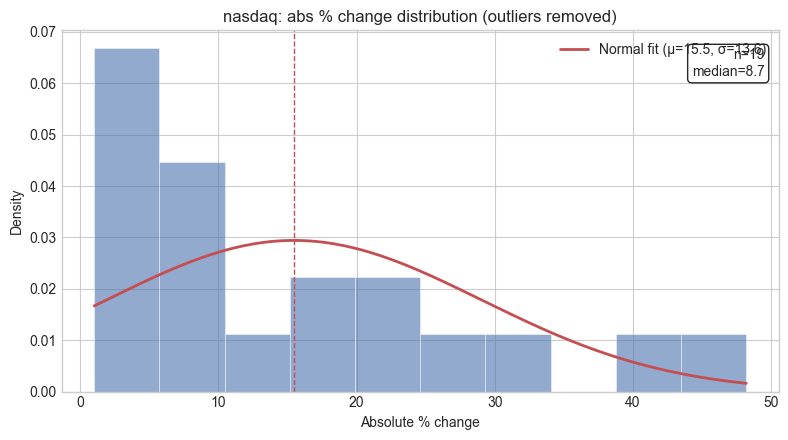

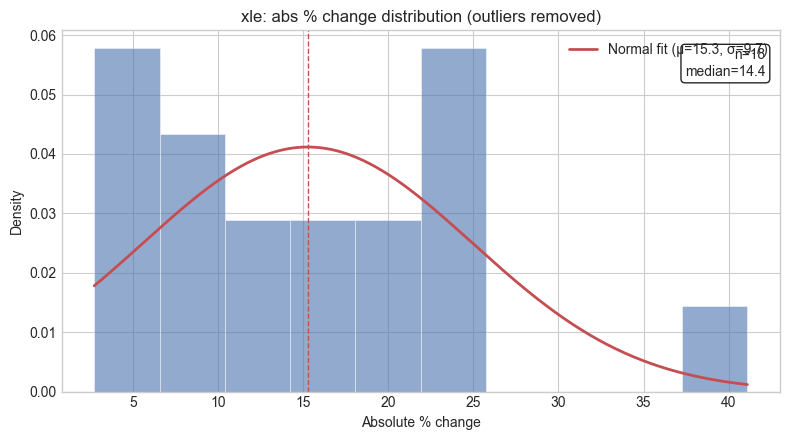

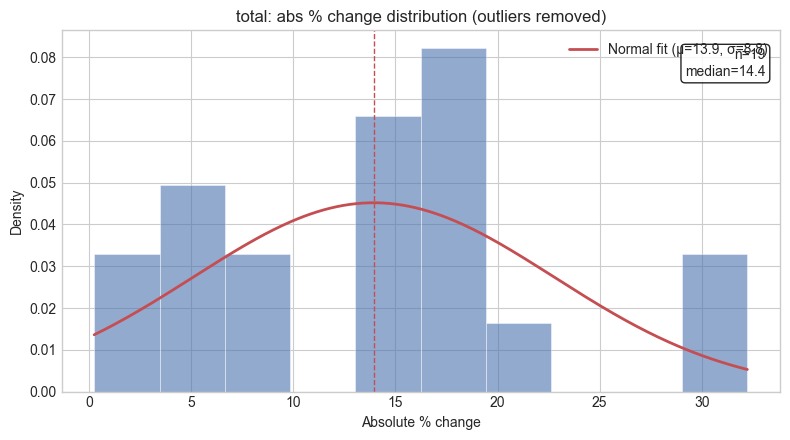

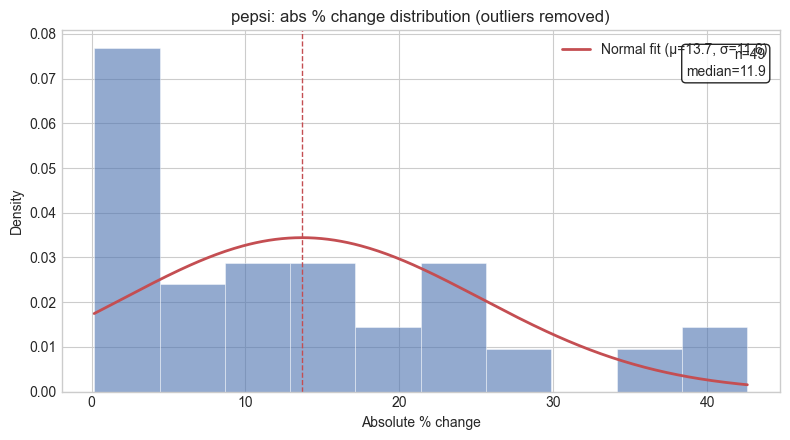

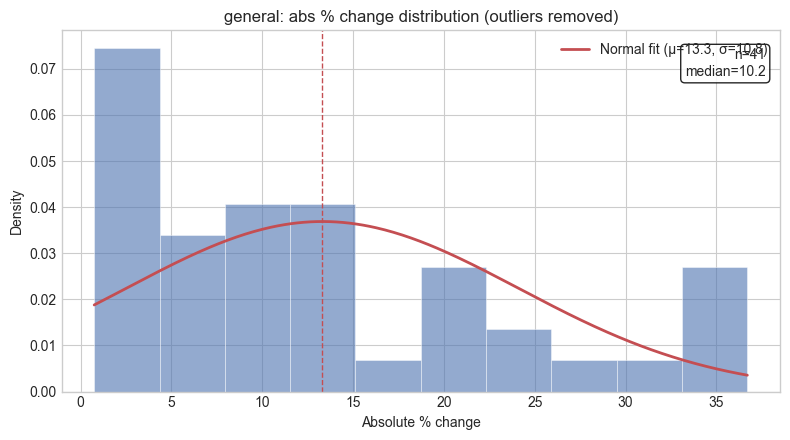

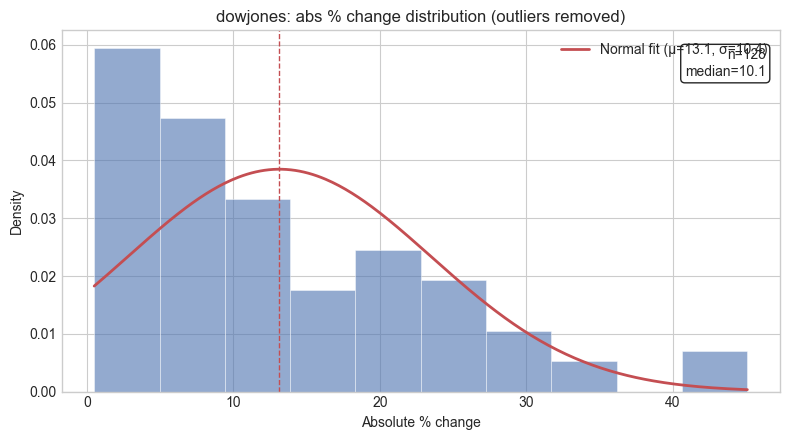

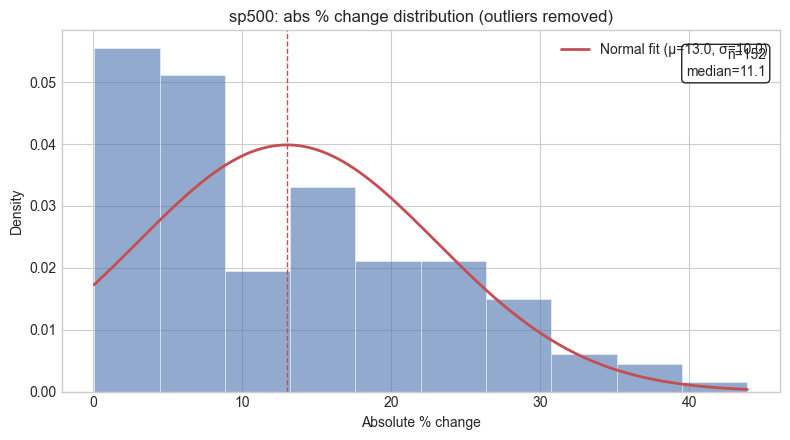

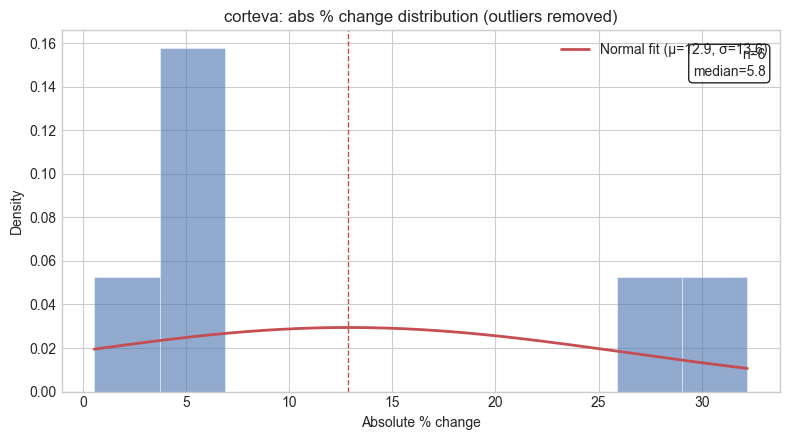

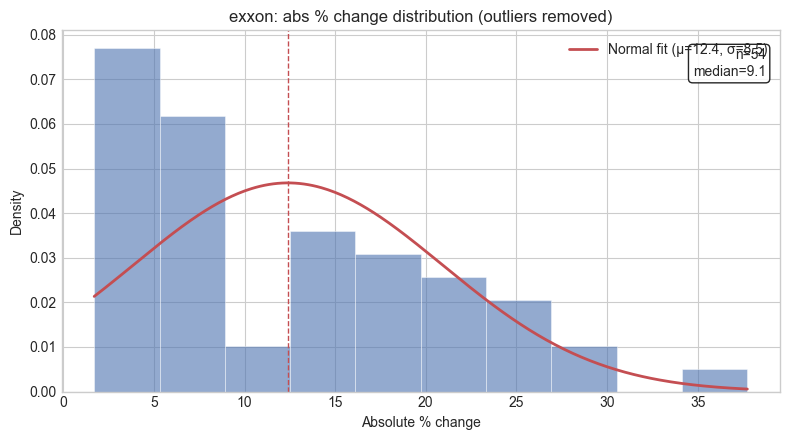

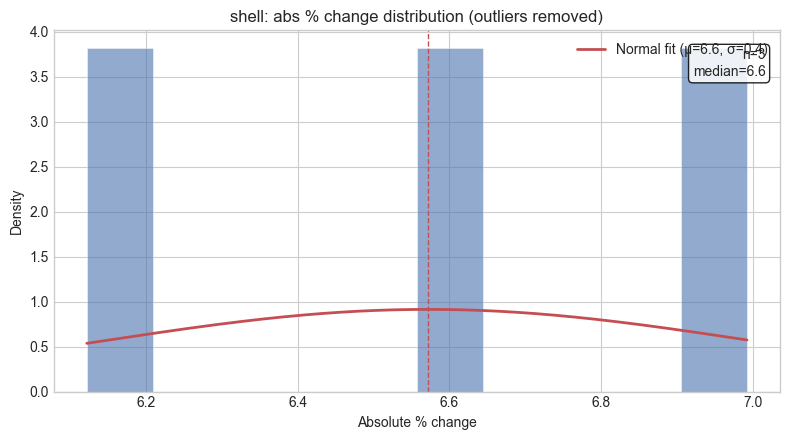

Saved per-company plots to: artifacts/plots_no_outliers


In [23]:
# Distribution plots: histogram of abs % change + Normal overlay (cleaned)
# Saves plots to artifacts/plots_no_outliers/
plots_dir = ART_DIR / 'plots_no_outliers'
plots_dir.mkdir(exist_ok=True)

companies = summary['company'].tolist()
n = len(companies)

# One figure per company (clearer than massive grids)
for company in companies:
    x = obs.loc[obs['company'] == company, 'abs_pct_change'].dropna().astype(float).values
    if len(x) < 3:
        continue
    mu, sd = float(x.mean()), float(x.std(ddof=1))

    # Choose bins via Freedman–Diaconis rule (with fallback)
    q1, q3 = np.quantile(x, [0.25, 0.75])
    iqr = q3 - q1
    bin_width = 2 * iqr * (len(x) ** (-1/3)) if iqr > 0 else 0
    if bin_width > 0:
        bins = int(np.clip((x.max() - x.min()) / bin_width, 10, 60))
    else:
        bins = 30

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(x, bins=bins, density=True, alpha=0.6, color='#4C72B0', edgecolor='white', linewidth=0.5)

    grid = np.linspace(x.min(), x.max(), 300)
    if sd > 0:
        ax.plot(grid, norm.pdf(grid, loc=mu, scale=sd), color='#C44E52', linewidth=2,
                label=f'Normal fit (μ={mu:.1f}, σ={sd:.1f})')

    ax.axvline(mu, color='#C44E52', linestyle='--', linewidth=1)
    ax.set_title(f'{company}: abs % change distribution (outliers removed)')
    ax.set_xlabel('Absolute % change')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Annotate key stats
    med = float(np.median(x))
    ax.text(0.98, 0.95, f'n={len(x)}\nmedian={med:.1f}', transform=ax.transAxes,
            ha='right', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

    out_fp = plots_dir / f'{company}_abs_pct_change_no_outliers.png'
    fig.tight_layout()
    fig.savefig(out_fp, dpi=160)
    plt.show()

print(f'Saved per-company plots to: {plots_dir}')

In [24]:
# Load cleaned long-format observations (or reconstruct by removing outliers)
import pandas as pd
import numpy as np
import os

obs_path_no = 'artifacts/obs_long_clean_no_outliers.csv'
obs_path = 'artifacts/obs_long_clean.csv'
outliers_path = 'artifacts/outliers.csv'

if os.path.exists(obs_path_no):
    obs_no = pd.read_csv(obs_path_no)
    source = obs_path_no
else:
    obs = pd.read_csv(obs_path)
    outl = pd.read_csv(outliers_path)
    # Remove outliers by (company, window_end_index)
    key_cols = ['company', 'window_end_index']
    obs_no = (obs.merge(outl[key_cols].drop_duplicates(), on=key_cols, how='left', indicator=True)
                 .query('_merge == "left_only"')
                 .drop(columns=['_merge']))
    # Save for downstream consistency
    obs_no.to_csv(obs_path_no, index=False)
    source = obs_path

print('Loaded:', source)
print('obs_no shape:', obs_no.shape)
print('Columns:', list(obs_no.columns))
obs_no.head()

Loaded: artifacts/obs_long_clean_no_outliers.csv
obs_no shape: (1070, 9)
Columns: ['company', 'file', 'window_end_index', 'S0', 'sigma', 'option_price', 'future_price', 'pct_change', 'abs_pct_change']


,company,file,window_end_index,S0,sigma,option_price,future_price,pct_change,abs_pct_change
0,GE,GE_Vernova_us_d.csv,220,375.200,0.542257,85.416768,834.61,99.678367,99.678367
1,amazon,amazon_us_d.csv,6978,226.630,0.550722,52.316841,204.90,-32.673009,32.673009
2,amazon,amazon_us_d.csv,6726,169.800,0.558459,39.692391,226.65,10.104599,10.104599
3,amazon,amazon_us_d.csv,6474,99.700,0.566037,23.590011,170.98,47.833490,47.833490
4,amazon,amazon_us_d.csv,6222,153.294,0.568807,36.430446,99.54,-58.831035,58.831035


In [25]:
# Aggregate outlier-removed observations to compute per-company avg absolute % error
avg_no_outliers = (obs_no.groupby('company', as_index=False)
                   .agg(avg_abs_pct_change_no_outliers=('abs_pct_change', 'mean'),
                        n_windows=('abs_pct_change', 'size'))
                   .sort_values('avg_abs_pct_change_no_outliers', ascending=False)
                   .reset_index(drop=True))

avg_no_outliers

,company,avg_abs_pct_change_no_outliers,n_windows
0,GE,99.678367,1
1,plug,78.926079,12
2,enph,67.007310,11
3,fslr,47.157574,18
4,apple,35.148565,39
5,amazon,31.794493,26
6,tesla,27.825070,12
7,walmart,27.594026,52
8,eog,23.638898,32
9,kmi,23.446549,14


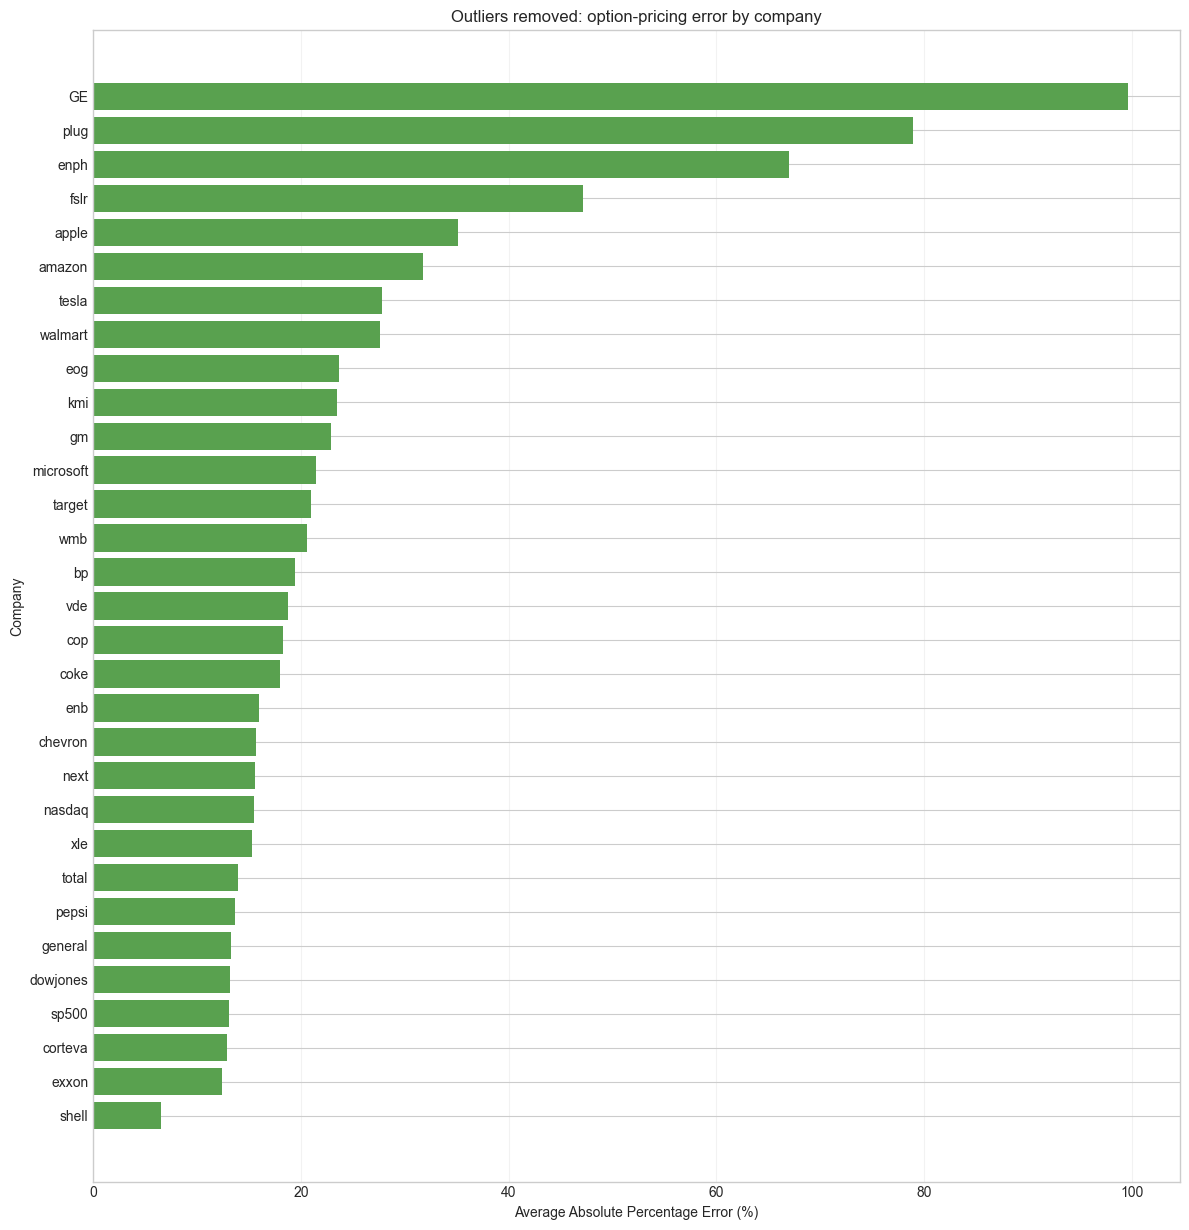

In [26]:
# Plot per-company average absolute % error with outliers removed
plot_no = avg_no_outliers.dropna(subset=['avg_abs_pct_change_no_outliers']).copy()
plot_no = plot_no.sort_values('avg_abs_pct_change_no_outliers', ascending=True)

plt.figure(figsize=(12, max(6, 0.4 * len(plot_no))))
plt.barh(plot_no['company'], plot_no['avg_abs_pct_change_no_outliers'], color='#59A14F')
plt.xlabel('Average Absolute Percentage Error (%)')
plt.ylabel('Company')
plt.title('Outliers removed: option-pricing error by company')
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()


## Notes
- Outliers are removed using the previously-generated outlier key table (`company`, `window_end_index`).
- The Normal overlay is a descriptive fit (μ=mean, σ=std) and not a claim that the data is truly Gaussian.